# Using custom states with `BGLS`

As mentioned in the [Getting started guide](start.ipynb), you can use `BGLS` with any representations of quantum states, so long as you specify how to `apply_gate`s and `compute_probability` from these states. Here we show an example of this using a custom `StateVector`.

## Setup

In [1]:
"""Setup."""
import itertools
from typing import Iterable, List

import numpy as np
import cirq

import bgls

## Defining a custom state

First we create a custom quantum state type to use with `BGLS`, here a simple class for a state vector.

In [2]:
"""Define a custom quantum state representation to use with BGLS."""
class StateVector:
    """Representation of a state vector."""
    def __init__(self, num_qubits: int) -> None:
        """Initialize a StateVector.
        
        Args:
            num_qubits: Number of qubits in the state.
        """
        self.num_qubits = num_qubits
        self.vector = np.zeros(2**num_qubits, dtype=complex)
        self.vector[0] = 1. + 0.j
    
    def copy(self) -> "StateVector":
        """Returns a copy of the StateVector."""
        new_state = StateVector(self.num_qubits)
        new_state.vector = np.copy(self.vector)
        return new_state

> Note: The `copy` method is required to use with `BGLS`.

For example, we can instantiate and use this class as follows.

In [3]:
state = StateVector(num_qubits=2)
state.vector

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

## Defining how to `apply_gate`s

After defining a state, we need to be able to apply gates to it. Below we do this using matrix multiplication, first assuming matrices and vectors and then for Cirq operations acting on our `StateVector` above.

> Note: The details of how to apply matrix gates aren't the important takeaway here, but rather how to plug this into `BGLS`. So, this cell can be safely skimmed. When defining your own `apply_gate` function, you'd write the equivalent of the following cell.

In [4]:
def apply_matrix_gate(gate: np.ndarray, target_bits: List[int], state: np.ndarray) -> None:
    """Applies a matrix gate to a state.
    
    Args:
        gate: The matrix of the gate to apply.
        target_bits: The (qu)bits the gate acts on.
        state: Wavefunction as a numpy array.
    """
    target_bits = target_bits[::-1]  # List of indices the gate is applied to.
    n = state.size  # For n qubits this is 2**n.

    # Flag whether we have worked on a given index already
    already_applied = np.zeros(n, dtype=int)
    for l in range(n):
        if already_applied[l]:
            continue
        subspace_indices = [l]
        for combo in powerset(target_bits):
            # E.g., [i0], [i1], [i0, i1], etc., one of these lists.
            if combo:  # Ignore the empty element.
                tempidx = l
                for bit in combo:
                    tempidx = flip_bit(tempidx, bit)
                subspace_indices.append(tempidx)

        apply_gate_to_subspace(gate, state, np.asarray(subspace_indices))
        for idx in subspace_indices:
            already_applied[idx] = 1


# Helper functions for above.
def apply_gate_to_subspace(gate: np.ndarray, state: np.ndarray, indices: np.ndarray) -> None:
    """Applies a matrix gate to a subspace.

    Args:
        gate: 2^q x 2^q numpy matrix, complex valued
        state: 2^n numpy array, complex valued
        indices: numpy array, integer valued, should be 2^q items in list
    """
    assert(indices.size == gate.shape[1])
    subspace = state[indices]
    output = gate.dot(subspace)
    state[indices] = output


def powerset(iterable: Iterable) -> itertools.chain:
    """Returns the powerset of an iterable."""
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))


def flip_bit(index: int, bit_to_flip: int) -> int:
    """Returns an integer equal to `index` but with the `i`th bit of index flipped,
    where `i` is `bit_to_flip`.

    Args:
        index: Integer to flip a bit of.
        bit_to_flip: Index of the bit in `index` to flip.
    """
    return index ^ (1 << bit_to_flip)

We can check that `apply_matrix_gate` works as intended for a simple Bell state preparation circuit.

In [5]:
apply_matrix_gate(cirq.unitary(cirq.H), target_bits=[0], state=state.vector)
print("StateVector after H:\t", state.vector)

apply_matrix_gate(cirq.unitary(cirq.CNOT), target_bits=[0, 1], state=state.vector)
print("StateVector after CNOT:\t", state.vector)

StateVector after H:	 [0.70710678+0.j 0.70710678+0.j 0.        +0.j 0.        +0.j]
StateVector after CNOT:	 [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


Now we format this for `BGLS` as follows.

In [6]:
def apply_gate(op: cirq.Operation, state: StateVector):
    """Applies the operation to the state, updating the state in place.
    
    Args:
        op: Operation to apply to the wavefunction.
        state: Wavefunction to apply the op to.
    """
    apply_matrix_gate(
        cirq.unitary(op.gate), 
        [q.x for q in sorted(op.qubits)], 
        state.vector
    )

## Defining how to `compute_probability`

Last, we need to be able to compute the probability of any bitstring for the given state. We do this for the `StateVector` below by indexing.

In [7]:
def compute_probability(state: StateVector, bitstring: str):
    """Returns the probability of samplign the bitstring in the given state.
    
    Args:
        state: A 
        bitstring: 
    """
    return np.abs(state.vector[int(bitstring[::-1], 2)])**2

## Using with `BGLS`

We can now use `BGLS` with our custom `StateVector` state, `apply_gate` function, and `compute_probability` function.

/home/ryan/prof/work/bgls/envbgls/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


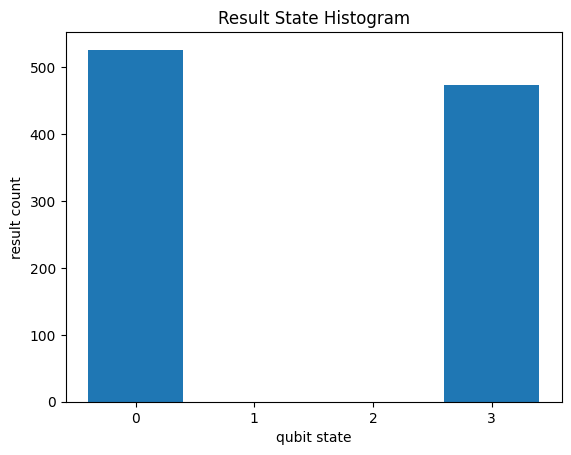

In [8]:
"""Using the custom state with BGLS."""
# Example circuit to run.
a, b = cirq.LineQubit.range(2)
circuit = cirq.Circuit(
    cirq.H.on(a),
    cirq.CNOT.on(a, b),
    cirq.measure(a, b, key="z"),
)

# Create a BGLS simulator with the custom state.
sim = bgls.Simulator(
    initial_state=StateVector(num_qubits=2),
    apply_gate=apply_gate,
    compute_probability=compute_probability
)

# Run the circuit.
results = sim.run(circuit, repetitions=1000)
_ = cirq.plot_state_histogram(results)

Note the returned results are formatted as usual for any Cirq circuit and the custom simulator supports all features supported by `BGLS`.